In [103]:
import numpy as np
import pandas as pd 
import seaborn as sb
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm
import cv2, gc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [104]:
train_csv = '/kaggle/input/planets-dataset/planet/planet/train_classes.csv'
test_csv = '/kaggle/input/planets-dataset/planet/planet/sample_submission.csv'

In [105]:
#Reading the train classes that contains the image names and tags from the directory
train_data = pd.read_csv(train_csv)
train_data.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [106]:
test_data= pd.read_csv(test_csv)
test_data.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [107]:
def  tag_mapping(mapping_csv):
    label_list = []
    for tag in train_data.tags.values:
        labels = tag.split(' ')
        for label in labels:
           label_list.append(label)
    label_list.sort()

    labels_map = {label_list[i]:i for i in range(len(label_list))}
    inv_labels_map = {i:label_list[i] for i in range(len(label_list))}
    
    tags = list(labels_map.keys()) 
    unique_tags= { tag: name for name, tag in enumerate(tags)}

    return labels_map, inv_labels_map, unique_tags


In [108]:
mapping, inv_mapping, unique_labels = tag_mapping(train_data)
print(len(mapping))
print(mapping)

17
{'agriculture': 12314, 'artisinal_mine': 12653, 'bare_ground': 13515, 'blooming': 13847, 'blow_down': 13948, 'clear': 42379, 'cloudy': 44468, 'conventional_mine': 44568, 'cultivation': 49115, 'habitation': 52775, 'haze': 55472, 'partly_cloudy': 62733, 'primary': 100246, 'road': 108317, 'selective_logging': 108657, 'slash_burn': 108866, 'water': 116277}


In [109]:
print(unique_labels)

{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}


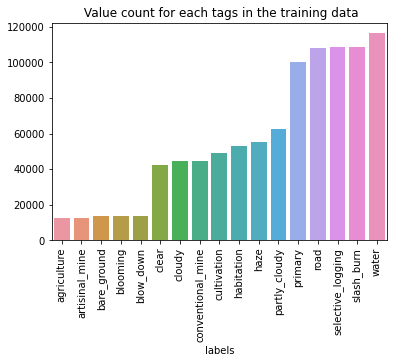

In [110]:
tags = list(mapping.keys()) 
y = list(mapping.values())
sb.barplot(x = tags, y = y);
plt.xlabel('labels');
plt.xticks(rotation = 90);
plt.title(' Value count for each tags in the training data');

In [111]:
columns=np.array(tags)

In [112]:
train_data_copy= train_data.copy()

In [113]:
train_data_copy['image_name'] = train_data_copy['image_name'].apply(lambda x: '{}.jpg'.format(x))
for labels in tags:
    train_data_copy[labels] = train_data_copy['tags'].apply(lambda x: 1 if labels in x.split() else 0)
    
train_data_copy.head()

,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_0.jpg,haze primary,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1.jpg,agriculture clear primary water,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2.jpg,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train_3.jpg,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


In [114]:
def fbeta(y_true, y_pred, beta = 2, epsilon = 1e-4):
    
    beta_squared = beta**2
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp
    
    precision = tp/(tp+fp+epsilon)
    recall = tp/(tp+fn+epsilon)
    
    fb = (1+beta_squared)*precision*recall / (beta_squared*precision+recall+epsilon)
    return fb

In [115]:
def multi_label_acc(y_true, y_pred, epsilon = 1e-4):
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp
    
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)
        
    tn = tf.reduce_sum(tf.cast(tf.logical_not(y_true), tf.float32) * tf.cast(tf.logical_not(y_pred), tf.float32), 
                       axis = 1)
    return (tp+tn)/(tp+tn+fp+fn+epsilon)

In [116]:
def model_building():
    model = Sequential()
    model.add(BatchNormalization(input_shape=(128, 128, 3)))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))

    opt = Adam(lr=1e-4)

    model.compile(loss='binary_crossentropy',optimizer=opt,metrics=[multi_label_acc, fbeta])
    
    return model

In [117]:

save_best_check_point = ModelCheckpoint(filepath = 'best_model.hdf5', monitor = 'val_fbeta', mode = 'max',
                                       save_best_only = True, save_weights_only = True)

In [118]:
train_image_gen = ImageDataGenerator(rescale = 1/255, validation_split = 0.2)

train_generator = train_image_gen.flow_from_dataframe(dataframe=train_data_copy,
                                                directory ="../input/planets-dataset/planet/planet/train-jpg",  
                                                x_col="image_name", y_col=columns, subset="training", 
                                                batch_size=16,seed=2021, shuffle=True, 
                                                class_mode="raw", target_size=(128,128))


val_generator = train_image_gen.flow_from_dataframe(dataframe=train_data_copy,
                                                directory ="../input/planets-dataset/planet/planet/train-jpg",  
                                                x_col="image_name", y_col=columns, subset="validation", 
                                                batch_size=16,seed=2021, shuffle=True, 
                                                class_mode="raw", target_size=(128,128))

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [119]:
step_train_size = int(np.ceil(train_generator.samples / train_generator.batch_size))
step_val_size = int(np.ceil(val_generator.samples / val_generator.batch_size))

In [ ]:
model1 = model_building()
model1.fit(x = train_generator, steps_per_epoch = step_train_size, validation_data = val_generator, 
           validation_steps = step_val_size,epochs = 25, 
           callbacks = [save_best_check_point])

In [ ]:
model2 = model_building()
model2.load_weights('best_model.hdf5')

In [ ]:
test_data_copy= test_data.copy()
test_data_copy['image_name'] = test_data_copy['image_name'].apply(lambda x: '{}.jpg'.format(x))
test_data_copy.head()

In [ ]:
test_data_images = test_data_copy.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)
test_data_images.head()

In [ ]:
additional_data_images=test_data_images.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)
additional_data_images.head()

In [ ]:
test_image_gen = ImageDataGenerator(rescale = 1/255)
def generator(images, path):
    test_generator = test_image_gen.flow_from_dataframe(dataframe=images,directory=path,x_col="image_name",
                                                        y_col=None, batch_size=16,shuffle=False, 
                                                        class_mode=None, target_size=(128,128))

    step_test_size = int(np.ceil(test_generator.samples/test_generator.batch_size))
    test_generator.reset()
    prediction = model2.predict(test_generator, steps = step_test_size, verbose = 1)
    file_names = test_generator.filenames
    return prediction, file_names

In [ ]:
pred1,file_names1 = generator( test_data_images,"../input/planets-dataset/planet/planet/test-jpg" )
pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ' '.join(np.array(labels)[x>0.5]), axis = 1)

result1 = pd.DataFrame({'image_name': file_names1, 'tags': pred_tags1})
result1.head()

In [ ]:
pred2,file_names2 = generator( additional_data_images,"../input/planets-dataset/test-jpg-additional/test-jpg-additional")
pred_tags2 = pd.DataFrame(pred2)
pred_tags2 = pred_tags2.apply(lambda x: ' '.join(np.array(labels)[x>0.5]), axis = 1)

result2 = pd.DataFrame({'image_name': file_names2, 'tags': pred_tags2})
result2.head()

In [ ]:
results = pd.concat([result1, result2])
results= results.reset_index().drop('index', axis =1)
results['image_name'] = results['image_name'].apply(lambda x: x[:-4])
print(results.shape)
results.head()

In [ ]:
results.to_csv('final_results.csv', index = False)